In [5]:
import os
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import neurite as ne

In [2]:
def process_acdc_patient(patient_path):
    """
    Process a single patient folder from the ACDC dataset.
    
    Args:
        patient_path (str): Path to the patient folder.

    Returns:
        list: A list containing end-systole and end-diastole slices.
    """
    pattern = r"frame(\d+)_slice_(\d+)"
    frames_dict = {}

    for file in os.listdir(patient_path):
        if file.endswith(".npy"):
            file_path = os.path.join(patient_path, file)
            data = np.load(file_path)  # Shape: (2, H, W)

            # Extract frame and slice numbers from the filename
            match = re.search(pattern, file)
            if not match:
                print(f"Error: {file} does not match the expected pattern.")
                continue
            frame = int(match.group(1))
            slice_num = int(match.group(2))

            # Organize slices by frame number
            if frame not in frames_dict:
                frames_dict[frame] = []
            frames_dict[frame].append((slice_num, data))

    # Sort slices within each frame by slice number
    for frame in frames_dict:
        frames_dict[frame].sort(key=lambda x: x[0])  # Sort by slice number

    # Assign frames to end-systole and end-diastole categories
    frame_numbers = sorted(frames_dict.keys())  # Sort frame numbers to differentiate categories
    end_systole_frame = frame_numbers[0]
    end_diastole_frame = frame_numbers[1] if len(frame_numbers) > 1 else None

    end_systole_slices = np.array([slice_data for _, slice_data in frames_dict[end_systole_frame]])
    end_diastole_slices = (
        np.array([slice_data for _, slice_data in frames_dict[end_diastole_frame]])
        if end_diastole_frame is not None
        else np.zeros((0, 2, 512, 512), dtype=np.float32)
    )

    return [end_systole_slices, end_diastole_slices]


def process_sunnybrook_patient(patient_path):
    """
    Process a single patient folder from the Sunnybrook dataset.
    
    Args:
        patient_path (str): Path to the patient folder.

    Returns:
        list: A list containing end-systole and end-diastole slices.
    """
    pattern = r"frame(\d+)"
    frames = []

    for file in sorted(os.listdir(patient_path)):
        if file.endswith(".npy"):
            file_path = os.path.join(patient_path, file)
            data = np.load(file_path)  # Shape: (2, H, W)
            
            # Extract frame number from the filename
            match = re.search(pattern, file)
            if not match:
                print(f"Error: {file} does not match the expected pattern.")
                continue
            frames.append(data)

    # Pair consecutive frames as end-systole and end-diastole
    end_systole_slices = []
    end_diastole_slices = []

    for i in range(len(frames) - 1):
        end_systole_slices.append(frames[i])
        end_diastole_slices.append(frames[i + 1])

    return [np.array(end_systole_slices), np.array(end_diastole_slices)]


def load_and_organize_data(input_path, dataset_type):
    """
    Load and organize data from the ACDC and Sunnybrook datasets.
    
    Args:
        input_path (str): Path to the directory containing the dataset folders.
        dataset_type (str): Type of dataset ('ACDC' or 'Sunnybrook').

    Returns:
        np.ndarray: Data organized in the required shape.
    """
    patient_data = {}

    for patient_folder in os.listdir(input_path):
        patient_path = os.path.join(input_path, patient_folder)
        if not os.path.isdir(patient_path):
            continue

        if dataset_type == 'ACDC':
            print(f"Processing patient {patient_folder} in the ACDC dataset...")
            patient_data[patient_folder] = process_acdc_patient(patient_path)
        elif dataset_type == 'Sunnybrook':
            print(f"Processing patient {patient_folder} in the SunnyBrook dataset...")
            patient_data[patient_folder] = process_sunnybrook_patient(patient_path)
        else:
            raise ValueError("Unsupported dataset type. Choose 'ACDC' or 'Sunnybrook'.")

    # Determine max slices across all patients
    num_patients = len(patient_data)
    max_slices = max(
        max(data[0].shape[0], data[1].shape[0]) for data in patient_data.values()
    )

    # Initialize final array
    final_data = np.zeros(
        (num_patients, 2, max_slices, 2, 512, 512),
        dtype=np.float32
    )

    # Populate the final array
    for i, (patient, data) in enumerate(patient_data.items()):
        for stage_idx, stage_data in enumerate(data):
            num_slices = stage_data.shape[0]
            final_data[i, stage_idx, :num_slices] = stage_data

    return final_data


def load_combined_data(acdc_path, sunnybrook_path, output_path):
    """
    Load and combine data from both ACDC and Sunnybrook datasets, ensuring all dimensions match.
    
    Args:
        acdc_path (str): Path to the ACDC dataset.
        sunnybrook_path (str): Path to the Sunnybrook dataset.

    Returns:
        np.ndarray: Combined data organized in the required shape, with reduced precision (float16).
    """
    acdc_data = load_and_organize_data(acdc_path, 'ACDC').astype(np.float16)
    sunnybrook_data = load_and_organize_data(sunnybrook_path, 'Sunnybrook').astype(np.float16)

    # Get the maximum number of slices across both datasets
    max_slices = max(acdc_data.shape[2], sunnybrook_data.shape[2])

    # Function to pad the data along the slices axis (axis=2)
    def pad_data(data, max_slices):
        num_patients, stages, slices, channels, height, width = data.shape
        padded_data = np.zeros((num_patients, stages, max_slices, channels, height, width), dtype=np.float16)
        padded_data[:, :, :slices] = data
        return padded_data

    # Pad both datasets to ensure consistent slice dimensions
    acdc_data_padded = pad_data(acdc_data, max_slices)
    sunnybrook_data_padded = pad_data(sunnybrook_data, max_slices)

    # Combine both datasets
    combined_data = np.concatenate([acdc_data_padded, sunnybrook_data_padded], axis=0)

    # Save the combined data to a file
    np.save(output_path, combined_data)

    return combined_data


In [3]:
base_path = os.getcwd()

acdc_path = os.path.join(base_path, "../../Data/ACDC/database/train_numpy")
sunnybrook_path = os.path.join(base_path, "../../Data/Sunnybrook/Standardized_Numpy")
output_path = os.path.join(base_path, "../../Data/combined_data.npy")

combined_data = load_combined_data(acdc_path, sunnybrook_path, output_path)
print(f"Combined data shape: {combined_data.shape}")


Processing patient patient001 in the ACDC dataset...
Processing patient patient002 in the ACDC dataset...
Processing patient patient003 in the ACDC dataset...
Processing patient patient004 in the ACDC dataset...
Processing patient patient005 in the ACDC dataset...
Processing patient patient006 in the ACDC dataset...
Processing patient patient007 in the ACDC dataset...
Processing patient patient008 in the ACDC dataset...
Processing patient patient009 in the ACDC dataset...
Processing patient patient010 in the ACDC dataset...
Processing patient patient011 in the ACDC dataset...
Processing patient patient012 in the ACDC dataset...
Processing patient patient013 in the ACDC dataset...
Processing patient patient014 in the ACDC dataset...
Processing patient patient015 in the ACDC dataset...
Processing patient patient016 in the ACDC dataset...
Processing patient patient017 in the ACDC dataset...
Processing patient patient018 in the ACDC dataset...
Processing patient patient019 in the ACDC data

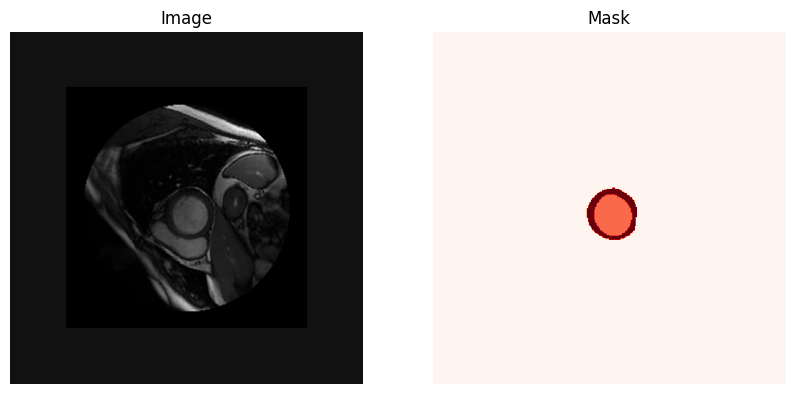

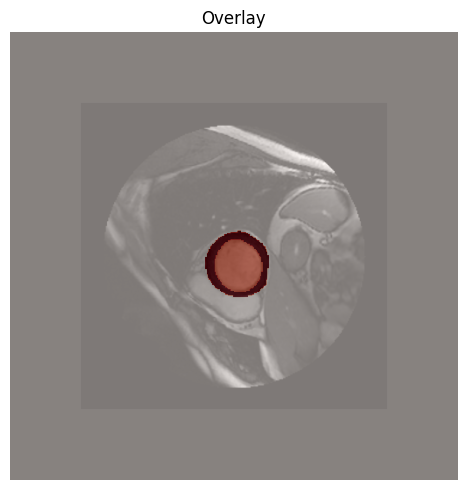

In [19]:
def plot_sample_slice(combined_data, patient_index=0, stage=0, slice_index=0):
    """
    Plots a sample slice from the combined dataset.

    Args:
        combined_data (np.ndarray): Combined dataset of shape 
                                     (num_patients, 2, max_slices, 2, 512, 512).
        patient_index (int): Index of the patient to visualize. Default is 0.
        stage (int): Index of the stage to visualize (0 = end-systole, 1 = end-diastole). Default is 0.
        slice_index (int): Index of the slice to visualize. Default is 0.
    """
    try:
        # Extract the image and mask
        sample_image = combined_data[patient_index, stage, slice_index, 0]
        sample_mask = combined_data[patient_index, stage, slice_index, 1]

        # Create the plots
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(sample_image, cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(sample_mask, cmap='Reds')
        plt.title('Mask')
        plt.axis('off')

        #plot the image and mask overlay
        plt.figure(figsize=(5, 5))
        plt.imshow(sample_image, cmap='gray')
        plt.imshow(sample_mask, cmap='Reds', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')


        plt.tight_layout()
        plt.show()

    except IndexError:
        print("Invalid index provided. Ensure the patient_index, stage, and slice_index are within bounds.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
plot_sample_slice(combined_data, patient_index=100, stage=1, slice_index=0)